In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
% matplotlib inline
plt.style.use('seaborn-whitegrid')

TRAIN_PATH = './train.csv'
TEST_PATH = './test.csv'

print(os.listdir("."))

['.cache', 'sample_submission.csv', '.sudo_as_admin_successful', 'ssl', '.bash_logout', 'taxi_fare_submission_tuned.csv', '.ipython', '.jupyter', '.ipynb_checkpoints', 'GCP-Coupons-Instructions.rtf', 'train.csv', '.local', '.profile', 'train.csv.zip', 'test.csv', '.config', '.rnd', '.kaggle', 'taxi_fare_submission_default.csv', '.nano', '55M - Tuned.ipynb', '.bash_history', '.bashrc', '10M - Default & Tuned.ipynb', '.ssh']


# Supporting functions

In [2]:
# For this plot and further analysis, we need a function to calculate the distance in miles between locations in lon,lat coordinates.
# This function is based on https://stackoverflow.com/questions/27928/
# calculate-distance-between-two-latitude-longitude-points-haversine-formula 
# return distance in miles

def add_time(df):
    # add time information
    df['year'] = df.pickup_datetime.apply(lambda t: t.year)
    df['weekday'] = df.pickup_datetime.apply(lambda t: t.weekday())
    df['hour'] = df.pickup_datetime.apply(lambda t: t.hour)
    
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) # 2*R*asin...

def add_travel_vector_features(df):
    # add new column to dataframe with distance in miles
    df['distance_miles'] = distance(df.pickup_latitude, df.pickup_longitude, \
                                          df.dropoff_latitude, df.dropoff_longitude)
    #df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    #df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()
    #df['abs_diff_lon_lat'] = (df.abs_diff_longitude + df.abs_diff_latitude)

def add_airport_dist(df):
    """
    Return minumum distance from pickup or dropoff coordinates to each airport.
    JFK: John F. Kennedy International Airport
    EWR: Newark Liberty International Airport
    LGA: LaGuardia Airport
    """
    jfk_coord = (40.639722, -73.778889)
    ewr_coord = (40.6925, -74.168611)
    lga_coord = (40.77725, -73.872611)
    
    pickup_lat = df['pickup_latitude']
    dropoff_lat = df['dropoff_latitude']
    pickup_lon = df['pickup_longitude']
    dropoff_lon = df['dropoff_longitude']
    
    pickup_jfk = distance(pickup_lat, pickup_lon, jfk_coord[0], jfk_coord[1]) 
    dropoff_jfk = distance(jfk_coord[0], jfk_coord[1], dropoff_lat, dropoff_lon) 
    pickup_ewr = distance(pickup_lat, pickup_lon, ewr_coord[0], ewr_coord[1])
    dropoff_ewr = distance(ewr_coord[0], ewr_coord[1], dropoff_lat, dropoff_lon) 
    pickup_lga = distance(pickup_lat, pickup_lon, lga_coord[0], lga_coord[1]) 
    dropoff_lga = distance(lga_coord[0], lga_coord[1], dropoff_lat, dropoff_lon) 
    
    df['jfk_dist'] = pd.concat([pickup_jfk, dropoff_jfk], axis=1).min(axis=1)
    df['ewr_dist'] = pd.concat([pickup_ewr, dropoff_ewr], axis=1).min(axis=1)
    df['lga_dist'] = pd.concat([pickup_lga, dropoff_lga], axis=1).min(axis=1)

def add_features(df):
    add_time(df)
    add_travel_vector_features(df)
    add_airport_dist(df)
    
    return df

def clean_df(df):
    print('Old size: %d' % len(df))
    
    # Remove observations with missing values
    df.dropna(how='any', axis='rows', inplace=True)

    # Removing observations with erroneous values
    mask = df['pickup_longitude'].between(-75, -73)
    mask &= df['dropoff_longitude'].between(-75, -73)
    mask &= df['pickup_latitude'].between(40, 42)
    mask &= df['dropoff_latitude'].between(40, 42)
    mask &= df['passenger_count'].between(0, 6)
    mask &= df['fare_amount'].between(0, 250)
    mask &= df['distance_miles'].between(0.05, 100)

    df = df[mask]
    
    print('New size: %d' % len(df))
    
    return df

***

# Train XGB with tuned settings

In [3]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
import xgboost as xgb

/home/ubuntu/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ubuntu/.local/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
%%time

chunksize = 10000000

# Set columns to most suitable type to optimize for memory usage
traintypes = {'fare_amount': 'float32',
              'pickup_datetime': 'str', 
              'pickup_longitude': 'float64',
              'pickup_latitude': 'float64',
              'dropoff_longitude': 'float64',
              'dropoff_latitude': 'float64',
              'passenger_count': 'uint8'}

cols = list(traintypes.keys())


df_list = [] # list to hold the batch dataframe
i=0

for df_chunk in pd.read_csv(TRAIN_PATH, usecols=cols, dtype=traintypes, chunksize=chunksize):
    
    # Neat trick from https://www.kaggle.com/btyuhas/bayesian-optimization-with-xgboost
    # Slicing off unnecessary components of the datetime and specifying the date 
    # format results in a MUCH more efficient conversion to a datetime object.
    df_chunk['pickup_datetime'] = df_chunk['pickup_datetime'].str.slice(0, 16)
    df_chunk['pickup_datetime'] = pd.to_datetime(df_chunk['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
    
    df_chunk = add_features(df_chunk)
    df_chunk = clean_df(df_chunk)
    
    # Alternatively, append the chunk to list and merge all
    df_list.append(df_chunk) 
    
# Merge all dataframes into one dataframe
df_train = pd.concat(df_list)

# Delete the dataframe list to release memory
del df_list

# See what we have loaded
df_train.info()

Old size: 10000000
New size: 9632462
Old size: 10000000
New size: 9633144
Old size: 10000000
New size: 9633099
Old size: 10000000
New size: 9632391
Old size: 10000000
New size: 9633900
Old size: 5423856
New size: 5224950
<class 'pandas.core.frame.DataFrame'>
Int64Index: 53389946 entries, 0 to 55423855
Data columns (total 14 columns):
fare_amount          float32
pickup_datetime      datetime64[ns, UTC]
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      uint8
year                 int64
weekday              int64
hour                 int64
distance_miles       float64
jfk_dist             float64
ewr_dist             float64
lga_dist             float64
dtypes: datetime64[ns, UTC](1), float32(1), float64(8), int64(3), uint8(1)
memory usage: 5.4 GB
CPU times: user 5min 16s, sys: 33.4 s, total: 5min 50s
Wall time: 6min 11s


***

Memory optimization as described in :
https://www.dataquest.io/blog/pandas-big-data/

In [13]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

In [5]:
df_train_float = df_train.select_dtypes(include=['float64'])
converted_float = df_train_float.apply(pd.to_numeric,downcast='float')

print(mem_usage(df_train_float))
print(mem_usage(converted_float))

compare_floats = pd.concat([df_train_float.dtypes,converted_float.dtypes],axis=1)
#compare_floats.columns = ['before','after']
compare_floats.apply(pd.Series.value_counts)

In [27]:
df_train_int = df_train.select_dtypes(include=['int64'])
converted_int = df_train_int.apply(pd.to_numeric,downcast='integer')

print(mem_usage(df_train_int))
print(mem_usage(converted_int))

compare_ints = pd.concat([df_train_int.dtypes,converted_int.dtypes],axis=1)
#compare_ints.columns = ['before','after']
compare_ints.apply(pd.Series.value_counts)

1629.33 MB
611.00 MB


,0,1
int8,NaN,2.0
int16,NaN,1.0
int64,3.0,NaN


In [30]:
df_train[converted_float.columns] = converted_float
df_train[converted_int.columns] = converted_int

In [31]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53389946 entries, 0 to 55423855
Data columns (total 14 columns):
fare_amount          float32
pickup_datetime      datetime64[ns, UTC]
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      uint8
year                 int16
weekday              int8
hour                 int8
distance_miles       float32
jfk_dist             float32
ewr_dist             float32
lga_dist             float32
dtypes: datetime64[ns, UTC](1), float32(9), int16(1), int8(2), uint8(1)
memory usage: 2.8 GB


In [32]:
df_train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,hour,distance_miles,jfk_dist,ewr_dist,lga_dist
0,4.5,2009-06-15 17:26:00+00:00,-73.844315,40.721317,-73.841614,40.712276,1,2009,0,17,0.640487,5.994456,17.102032,4.138639
1,16.9,2010-01-05 16:52:00+00:00,-74.016045,40.711304,-73.979271,40.782005,1,2010,1,16,5.250669,13.375410,8.096244,5.589884
2,5.7,2011-08-18 00:35:00+00:00,-73.982735,40.761269,-73.991241,40.750561,2,2011,3,0,0.863411,13.505527,10.117290,5.867491
3,7.7,2012-04-21 04:30:00+00:00,-73.987129,40.733143,-73.991570,40.758091,1,2012,5,4,1.739386,12.676698,9.910674,6.364004
4,5.3,2010-03-09 07:51:00+00:00,-73.968094,40.768009,-73.956657,40.783764,1,2010,1,7,1.242218,13.295920,11.723477,4.420030


***

In [33]:
cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year', 'weekday', 'hour', 'distance_miles', 'jfk_dist', 'ewr_dist', 'lga_dist']
X = df_train[cols]
y = df_train['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

matrix_train = xgb.DMatrix(X_train,label=y_train)
matrix_test = xgb.DMatrix(X_test,label=y_test)

In [34]:
%%time

params = {
    'objective':'reg:linear',
    'eval_metric':'rmse',
    #
    'max_depth': 7, #Result of tuning with CV
    'eta':.075, #Result of tuning with CV
    'subsample': 0.9, #Result of tuning with CV
    'colsample_bytree': 0.8, #Result of tuning with CV
    'colsample_bylevel': 0.6,
    'min_child_weight': 2,
    #
    'silent': 1,
    'nthread': 8,
    'n_jobs': 8,
}

model2 = xgb.train(
    params=params,
    dtrain=matrix_train,
    num_boost_round=1000,
    early_stopping_rounds=10,
    evals=[(matrix_test,'test')],
)

[22:26:30] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[0]	test-rmse:13.3432
Will train until test-rmse hasn't improved in 10 rounds.
[1]	test-rmse:12.4702
[2]	test-rmse:11.6199
[3]	test-rmse:10.8471
[4]	test-rmse:10.1259
[5]	test-rmse:9.46778
[6]	test-rmse:8.8597
[7]	test-rmse:8.35549
[8]	test-rmse:7.88693
[9]	test-rmse:7.42625
[10]	test-rmse:7.01121
[11]	test-rmse:6.62106
[12]	test-rmse:6.26731
[13]	test-rmse:5.96967
[14]	test-rmse:5.70008
[15]	test-rmse:5.43319
[16]	test-rmse:5.21378
[17]	test-rmse:4.99557
[18]	test-rmse:4.79899
[19]	test-rmse:4.62638
[20]	test-rmse:4.47192
[21]	test-rmse:4.33416
[22]	test-rmse:4.21368
[23]	test-rmse:4.10733
[24]	test-rmse:4.02115
[25]	test-rmse:3.9331
[26]	test-rmse:3.86639
[27]	test-rmse:3.79638
[28]	test-rmse:3.7431
[29]	test-rmse:3.69736
[30]	test-rmse:3.64789
[31]	test-rmse:3.60324
[32]	test-rmse:3.56443
[33]	test-rmse:3.52887
[3

[338]	test-rmse:3.05368
[339]	test-rmse:3.05344
[340]	test-rmse:3.05322
[341]	test-rmse:3.05314
[342]	test-rmse:3.05295
[343]	test-rmse:3.05289
[344]	test-rmse:3.05276
[345]	test-rmse:3.05236
[346]	test-rmse:3.05225
[347]	test-rmse:3.0522
[348]	test-rmse:3.05206
[349]	test-rmse:3.052
[350]	test-rmse:3.05187
[351]	test-rmse:3.05176
[352]	test-rmse:3.05165
[353]	test-rmse:3.0517
[354]	test-rmse:3.05165
[355]	test-rmse:3.05143
[356]	test-rmse:3.05117
[357]	test-rmse:3.05109
[358]	test-rmse:3.05098
[359]	test-rmse:3.05077
[360]	test-rmse:3.05065
[361]	test-rmse:3.05059
[362]	test-rmse:3.05041
[363]	test-rmse:3.05027
[364]	test-rmse:3.05022
[365]	test-rmse:3.05019
[366]	test-rmse:3.04998
[367]	test-rmse:3.04994
[368]	test-rmse:3.04979
[369]	test-rmse:3.0495
[370]	test-rmse:3.04934
[371]	test-rmse:3.04906
[372]	test-rmse:3.049
[373]	test-rmse:3.04883
[374]	test-rmse:3.04862
[375]	test-rmse:3.04855
[376]	test-rmse:3.04841
[377]	test-rmse:3.04837
[378]	test-rmse:3.04841
[379]	test-rmse:3.04825

[681]	test-rmse:3.02283
[682]	test-rmse:3.02273
[683]	test-rmse:3.02268
[684]	test-rmse:3.02262
[685]	test-rmse:3.0226
[686]	test-rmse:3.02247
[687]	test-rmse:3.02241
[688]	test-rmse:3.02219
[689]	test-rmse:3.02204
[690]	test-rmse:3.02195
[691]	test-rmse:3.02184
[692]	test-rmse:3.02176
[693]	test-rmse:3.02165
[694]	test-rmse:3.0216
[695]	test-rmse:3.0216
[696]	test-rmse:3.02151
[697]	test-rmse:3.02148
[698]	test-rmse:3.02146
[699]	test-rmse:3.02147
[700]	test-rmse:3.02148
[701]	test-rmse:3.02147
[702]	test-rmse:3.02147
[703]	test-rmse:3.02138
[704]	test-rmse:3.02139
[705]	test-rmse:3.02128
[706]	test-rmse:3.02122
[707]	test-rmse:3.02124
[708]	test-rmse:3.02123
[709]	test-rmse:3.02115
[710]	test-rmse:3.02106
[711]	test-rmse:3.02095
[712]	test-rmse:3.02094
[713]	test-rmse:3.02082
[714]	test-rmse:3.0208
[715]	test-rmse:3.02058
[716]	test-rmse:3.02049
[717]	test-rmse:3.0205
[718]	test-rmse:3.02039
[719]	test-rmse:3.02043
[720]	test-rmse:3.02041
[721]	test-rmse:3.02036
[722]	test-rmse:3.020

### Verify performance of training against validation set

In [35]:
from sklearn.metrics import mean_squared_error
import math

y_pred_tuned = model2.predict(matrix_test, ntree_limit=model2.best_ntree_limit)
print('Score:', math.sqrt(mean_squared_error(y_test, y_pred_tuned)))

Score: 3.010505877342246


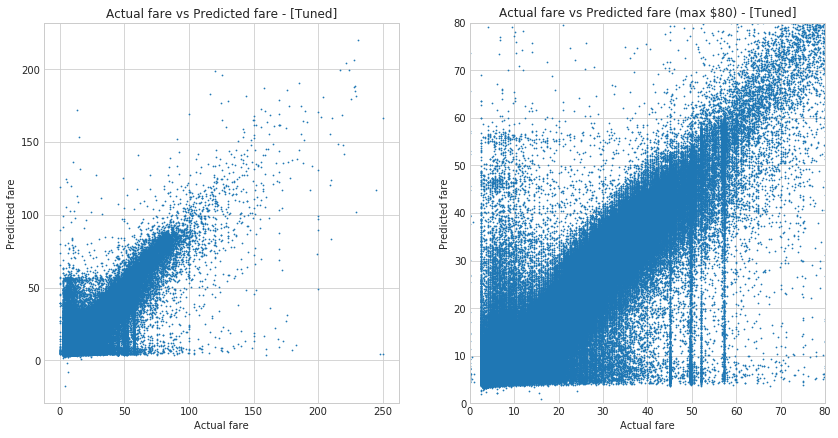

In [36]:
# plot prediction and actual data

plt.figure(figsize=(14,7))
plt.subplot(1, 2, 1)
plt.plot(y_test, y_pred_tuned, '.', markersize=1.5)
plt.title('Actual fare vs Predicted fare - [Tuned]')
plt.xlabel('Actual fare')
plt.ylabel('Predicted fare')

plt.subplot(1, 2, 2)
plt.plot(y_test, y_pred_tuned, '.', markersize=1.5)
plt.title('Actual fare vs Predicted fare (max $80) - [Tuned]')
plt.xlabel('Actual fare')
plt.ylabel('Predicted fare')
plt.xlim(0, 80)
plt.ylim(0, 80)

plt.show()

# Make predictions on the test set

In [37]:
df_test =  pd.read_csv(TEST_PATH)
df_test['pickup_datetime'] = df_test['pickup_datetime'].str.slice(0, 16)
df_test['pickup_datetime'] = pd.to_datetime(df_test['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')

add_features(df_test)

cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year', 'weekday', 'hour', 'distance_miles', 'jfk_dist', 'ewr_dist', 'lga_dist']
X_test = df_test[cols]

X_test.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,hour,distance_miles,jfk_dist,ewr_dist,lga_dist
0,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,13,1.443607,12.819377,10.424234,5.351000
1,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,13,1.507044,12.208516,9.455977,7.112463
2,-73.982524,40.751260,-73.979654,40.746139,1,2011,5,11,0.384398,12.832843,10.556347,6.000188
3,-73.981160,40.767807,-73.990448,40.751635,1,2012,5,21,1.218529,13.513499,10.184917,5.717171
4,-73.966046,40.789775,-73.988565,40.744427,1,2012,5,21,3.347514,13.152839,10.088114,4.964186


In [39]:
#pred_test_default = model1.predict(xgb.DMatrix(X_test), ntree_limit = model1.best_ntree_limit)
pred_test_tuned = model2.predict(xgb.DMatrix(X_test), ntree_limit = model2.best_ntree_limit)

In [40]:
#Create submission file

'''submission_default = pd.DataFrame({
        "key": df_test['key'],
        "fare_amount": pred_test_default.round(2)
})'''

submission_tuned = pd.DataFrame({
        "key": df_test['key'],
        "fare_amount": pred_test_tuned.round(2)
})

#submission_default = submission_default[['key', 'fare_amount']]
submission_tuned = submission_tuned[['key', 'fare_amount']]

#submission_default.to_csv('taxi_fare_submission_default.csv',index=False)
submission_tuned.to_csv('taxi_fare_submission_tuned.csv',index=False)

In [41]:
#submission_default.head()

In [42]:
submission_tuned.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.98
1,2015-01-27 13:08:24.0000003,11.34
2,2011-10-08 11:53:44.0000002,4.42
3,2012-12-01 21:12:12.0000002,7.48
4,2012-12-01 21:12:12.0000003,13.56
